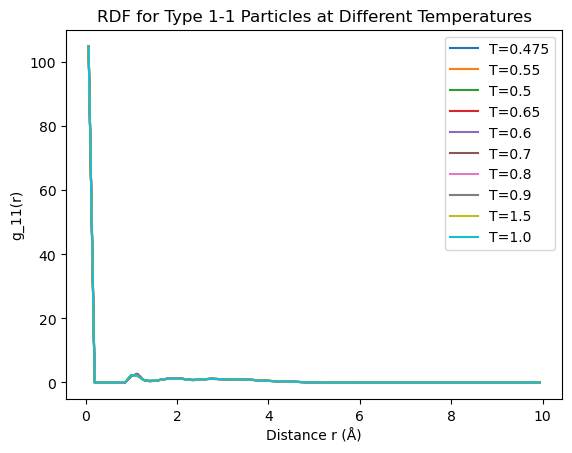

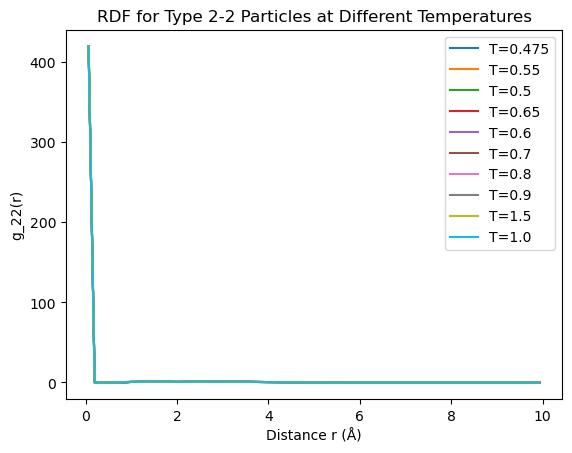

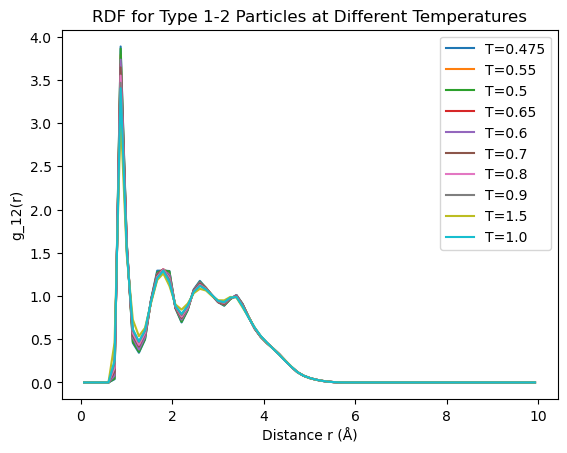

In [2]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import re
from MDAnalysis.analysis.rdf import InterRDF  # 导入 InterRDF

# 创建 Figures 文件夹
output_dir = "Figures"
os.makedirs(output_dir, exist_ok=True)

# 获取 .lammpstrj 和 .dcd 文件路径
lammpstrj_files = sorted(glob.glob("../equil/*.lammpstrj"))  # 替换为实际的 .lammpstrj 文件路径
dcd_files = sorted(glob.glob("../prod/*.unwrap.dcd"))  # 替换为实际的 .dcd 文件路径

# 定义 RDF 计算函数
def calculate_rdf(universe, type1, type2, r_range=(0.0, 10.0)):
    rdf_anal = InterRDF(universe.select_atoms(f"type {type1}"), 
                        universe.select_atoms(f"type {type2}"), 
                        range=r_range)
    rdf_anal.run()
    return rdf_anal.results.bins, rdf_anal.results.rdf  # 使用更新的属性

# 用于存储所有温度的 RDF 数据
rdf_data_11 = {}
rdf_data_22 = {}
rdf_data_12 = {}

# 循环加载拓扑和轨迹文件，计算 RDF
for lammpstrj_file, dcd_file in zip(lammpstrj_files, dcd_files):
    # 使用正则表达式从文件名中提取温度
    match = re.search(r'T(\d+\.?\d*)', lammpstrj_file)
    if match:
        temp = float(match.group(1))  # 提取到的温度值转换为浮点数
    else:
        print(f"无法从文件名 {lammpstrj_file} 提取温度信息")
        continue
    
    universe = mda.Universe(lammpstrj_file, dcd_file, topology_format="LAMMPSDUMP")
    
    # 计算 RDF
    r, g_11 = calculate_rdf(universe, type1=1, type2=1)
    _, g_22 = calculate_rdf(universe, type1=2, type2=2)
    _, g_12 = calculate_rdf(universe, type1=1, type2=2)

    # 存储每个温度的 RDF 数据
    rdf_data_11[temp] = (r, g_11)
    rdf_data_22[temp] = (r, g_22)
    rdf_data_12[temp] = (r, g_12)

# 绘制每种粒子对的 RDF
plt.figure()
for temp, (r, g_11) in rdf_data_11.items():
    plt.plot(r, g_11, label=f'T={temp}')
plt.xlabel('Distance r (Å)')
plt.ylabel('g_11(r)')
plt.title('RDF for Type 1-1 Particles at Different Temperatures')
plt.legend()
plt.savefig(f"{output_dir}/RDF_g11.png")
plt.show()

plt.figure()
for temp, (r, g_22) in rdf_data_22.items():
    plt.plot(r, g_22, label=f'T={temp}')
plt.xlabel('Distance r (Å)')
plt.ylabel('g_22(r)')
plt.title('RDF for Type 2-2 Particles at Different Temperatures')
plt.legend()
plt.savefig(f"{output_dir}/RDF_g22.png")
plt.show()

plt.figure()
for temp, (r, g_12) in rdf_data_12.items():
    plt.plot(r, g_12, label=f'T={temp}')
plt.xlabel('Distance r (Å)')
plt.ylabel('g_12(r)')
plt.title('RDF for Type 1-2 Particles at Different Temperatures')
plt.legend()
plt.savefig(f"{output_dir}/RDF_g12.png")
plt.show()
